In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download vpapenko/nails-segmentation
!unzip /content/nails-segmentation.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 34% 9.00M/26.2M [00:00<00:01, 12.6MB/s]
100% 26.2M/26.2M [00:00<00:00, 31.2MB/s]


In [8]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 31.1 MB/s 


In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import numpy as np
import torchvision
from PIL import Image
from torchmetrics import JaccardIndex
from torchvision import transforms
%matplotlib inline

## CONFIG

In [4]:
THRESHOLD = -0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

PATH_IMGS = "/content/images/"
PATH_MASKS = "/content/labels/"

## Vanila UNet

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.transforms = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),
                            )
    def forward(self, x):
        return self.transforms(x)


class UpTransform(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_height = x2.size()[2] - x1.size()[2]
        diff_width = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diff_width // 2, diff_width - diff_width // 2, diff_height // 2, diff_height - diff_height // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes

        self.input_transform = DoubleConv(1, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64,128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128,256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256,512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512,1024))

        self.up1 = UpTransform(1024, 512)
        self.up2 = UpTransform(512, 256)
        self.up3 = UpTransform(256, 128)
        self.up4 = UpTransform(128, 64)

        self.output_transform = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.input_transform(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.output_transform(x)
        return x

## Resnet18 UNet

In [10]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images_names, masks_names):
        self.img_names = images_names
        self.mask_names = masks_names
        
        transform = transforms.Compose(
                [transforms.Resize((224,224)),
                 transforms.ToTensor()
                 ])
    
        self.trans = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_path = self.img_names[index]
        mask_path = self.mask_names[index]
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img_tensor = self.trans(img)
        mask_tensor = self.trans(mask)
        return img_tensor, mask_tensor

In [12]:
img_names = [PATH_IMGS+filename for filename in os.listdir(PATH_IMGS)]
mask_names = [PATH_MASKS+filename for filename in os.listdir(PATH_MASKS)]
print(len(img_names))
print(len(mask_names))
train_images, test_images, train_masks, test_masks = train_test_split(img_names, mask_names, test_size=0.2, random_state=0)

train_dataset = Dataset(train_images, train_masks)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = Dataset(test_images, test_masks)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

52
52


In [13]:
from torch import Tensor 

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):
    #print(pred.shape, target.shape)
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def compute_loss(y_pred, y_true):
    return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=0)),dim=0))

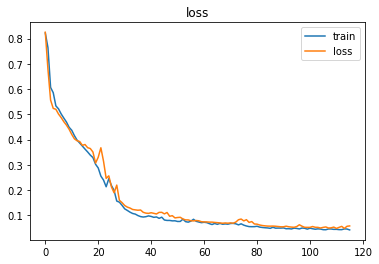

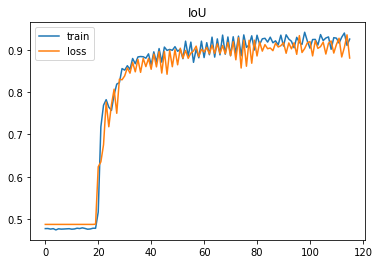


Epoch: 116


KeyboardInterrupt: ignored

In [15]:
from collections import defaultdict

model = ResNetUNet(3)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0001)
jaccard = JaccardIndex(num_classes=2)
loss_fn = calc_loss
num_epochs = 200

loss_history = {'train': [], 'test': []}
iou_history = {'train': [], 'test': []}
for epoch in range(num_epochs):
    print('\nEpoch:', epoch)
    epoch_train_loss = 0
    epoch_train_iou = 0
    metrics = defaultdict(float)
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x) # y = f(x)
        loss = calc_loss(y_pred, y, metrics)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_loss += loss.item()

        epoch_train_iou += jaccard(y_pred.cpu(), y.int().cpu()).item()

    epoch_test_loss = 0
    epoch_test_iou = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x) # y = f(x)
        loss = calc_loss(y_pred, y, metrics)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_test_loss += loss.item()

        epoch_test_iou += jaccard(y_pred.cpu(), y.int().cpu()).item()

    loss_history['train'].append(epoch_train_loss/len(train_loader))
    loss_history['test'].append(epoch_test_loss/len(test_loader))

    iou_history['train'].append(epoch_train_iou/len(train_loader))
    iou_history['test'].append(epoch_test_iou/len(test_loader))

    clear_output(True)
    plt.plot(range((len(loss_history['train']))), loss_history['train'])
    plt.plot(range((len(loss_history['test']))), loss_history['test'])
    plt.title('loss')
    plt.legend(['train', 'valid'])
    plt.show()

    plt.plot(range((len(iou_history['train']))), iou_history['train'])
    plt.plot(range((len(iou_history['test']))), iou_history['test'])
    plt.title('IoU')
    plt.legend(['train', 'valid'])
    plt.show()


In [17]:
iou_history['test'][-20:]

[0.9340745806694031,
 0.8941752910614014,
 0.9035078287124634,
 0.9169927835464478,
 0.9200018644332886,
 0.8860874176025391,
 0.9219881892204285,
 0.9038883447647095,
 0.9080497026443481,
 0.9187445044517517,
 0.8905121088027954,
 0.916073203086853,
 0.9215066432952881,
 0.8928177356719971,
 0.9130296111106873,
 0.9278998970985413,
 0.8835517168045044,
 0.9060894846916199,
 0.9359306693077087,
 0.8810412287712097]

/content/images/d639e532-db67-11e8-9658-0242ac1c0002.jpg


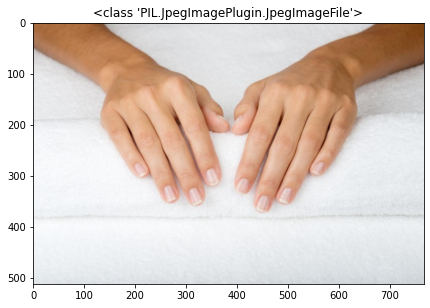

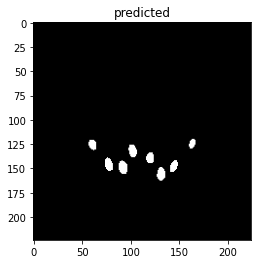

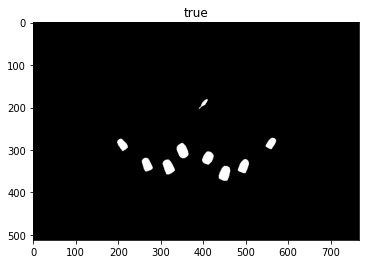

/content/images/d639e532-db67-11e8-9658-0242ac1c0002.jpg


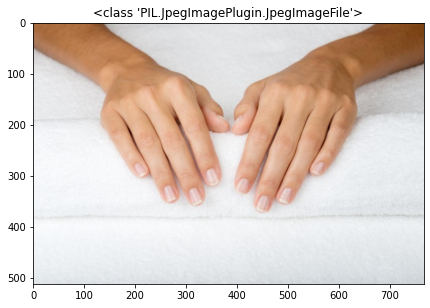

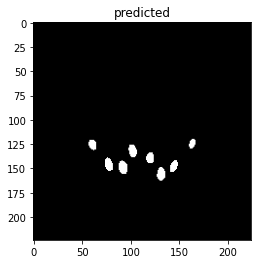

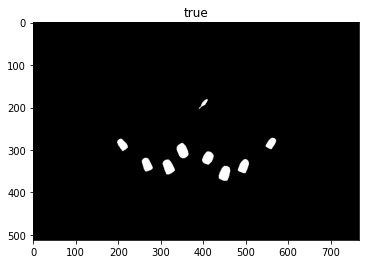

/content/images/4c47ee66-e402-11e8-97db-0242ac1c0002.jpg


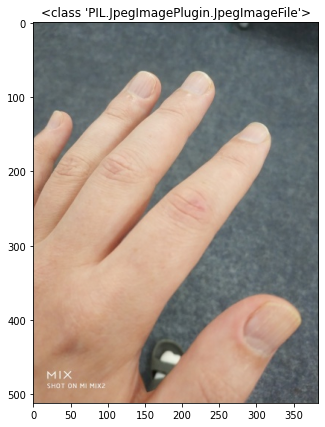

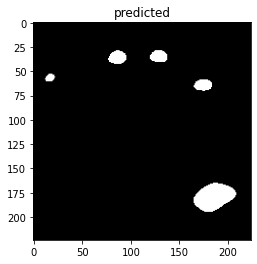

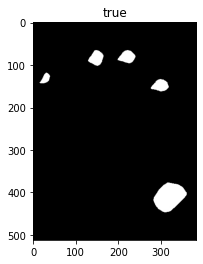

In [18]:
model.eval()
for i in range(3):
    n = np.random.choice(len(test_dataset))
    imgdir = test_dataset.img_names[n]
    maskdir = test_dataset.mask_names[n]
    print(imgdir)
    img = Image.open(imgdir)
    mask = Image.open(maskdir)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(type(img))
    fig.set_figwidth(7)
    fig.set_figheight(7)
    plt.show()
    
    T1 = test_dataset.trans(img).unsqueeze(0).to(device)
    y_pred = model(T1)
    T = y_pred > THRESHOLD
    T = T.int()
    plt.imshow(T[0][0].cpu().detach().numpy(),cmap='gray')
    plt.title('predicted')
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.title('true')
    plt.show()